In [1]:
import numpy as np
import scipy

import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats

# Homework 2
## Hypothesis testing

Each task is worth 5 points, 20 points in total. Additionally, some tasks allow you to get a bonus point, that **can not** increase your total score for the homework beyond the maximum, but can compensate for some occasionally lost points.

### Task 1: multiple comparisons

A randomized, double-blind experiment was conducted to assess the
effectiveness of several drugs for reducing postoperative nausea. The
data are as follows:

In [2]:
df1 = pd.DataFrame({'Drug': ['Placebo', 'Chlorpromazine', 'Dimenhydrinate', 'Pentobarbital (100 mg)', 'Pentobarbital (150 mg)'],
                    'Number of Patients': [80, 75, 85, 67, 85],
                    'Incidence of Nausea': [45, 26, 52, 35, 37]})
df1

,Drug,Number of Patients,Incidence of Nausea
0,Placebo,80,45
1,Chlorpromazine,75,26
2,Dimenhydrinate,85,52
3,Pentobarbital (100 mg),67,35
4,Pentobarbital (150 mg),85,37


1. Test each drug versus the placebo at the 5% level. Also, report
the estimated odds–ratios. Summarize your findings. (2 points)
2. Use the Bonferroni and the FDR method to adjust for multiple
testing. (Beecher (1959)) (3 points)
3. Reproduce plot similar to Figure 10.6 from the book, displaying observed $p$-values and different thresholds used (1 bonus point)

*Hint*. Use simple $H_0$: "$p_{drug} = p_{placebo}$".

In [3]:
def bernoulli_mean_comparison_test(n_x, count_x, n_y, count_y, significance_level):
    mean_estimation_x, mean_estimation_y = count_x / n_x, count_y / n_y
    variance_estimation_x, variance_estimation_y = mean_estimation_x * (1 - mean_estimation_x), mean_estimation_y * (1 - mean_estimation_y)
    
    variance_estimation = variance_estimation_x / n_x + variance_estimation_y / n_y
    test_statistic = np.abs((mean_estimation_x - mean_estimation_y) / np.sqrt(variance_estimation))
    quantile = stats.norm.ppf(1 - significance_level / 2)

    p_value = 2 * (1 - stats.norm.cdf(test_statistic))
    return test_statistic > quantile, p_value

In [4]:
n_x, count_x = df1.iloc[0, 1:].values.astype('float64')
significance_level = 0.05
p_values = []

for i in range(1, len(df1)):
    n_y, count_y = df1.iloc[i, 1:].values.astype('float64')
    hypothesis_denied, p_value = bernoulli_mean_comparison_test(n_x, count_x, n_y, count_y, significance_level)
    p_values.append(p_value)

    print(f'hypothesis about {df1.iloc[i, 0]} being Placebo')
    print(f'significance level: {significance_level}, denied: {hypothesis_denied}, p-value: {p_value:.4f}\n')

hypothesis about Chlorpromazine being Placebo
significance level: 0.05, denied: True, p-value: 0.0057

hypothesis about Dimenhydrinate being Placebo
significance level: 0.05, denied: False, p-value: 0.5202

hypothesis about Pentobarbital (100 mg) being Placebo
significance level: 0.05, denied: False, p-value: 0.6267

hypothesis about Pentobarbital (150 mg) being Placebo
significance level: 0.05, denied: False, p-value: 0.0996



* odds-ratios

In [5]:
counts = np.vstack([df1['Incidence of Nausea'].values, df1['Number of Patients'].values - df1['Incidence of Nausea'].values]).T

In [6]:
counts

array([[45, 35],
       [26, 49],
       [52, 33],
       [35, 32],
       [37, 48]])

In [7]:
odds_ratios = []

for i in range(1, len(df1)):
    odds_ratios.append(counts[i, 1] / counts[i, 0] / (counts[0, 1] / counts[0, 0]))

In [8]:
for i in range(len(odds_ratios)):
    print(f'OR between {df1.iloc[i + 1, 0]} and Placebo \n{odds_ratios[i]:.4f}\n')

OR between Chlorpromazine and Placebo 
2.4231

OR between Dimenhydrinate and Placebo 
0.8159

OR between Pentobarbital (100 mg) and Placebo 
1.1755

OR between Pentobarbital (150 mg) and Placebo 
1.6680



It seems to me that (in general) the higher the odds-ratio between drug and placebo, the less p-value for the hypothesis that this drug is placebo

* using Holm-Bonferroni strategy

In [9]:
significance_level = 0.05 / 4

for i in range(1, len(df1)):
    n_y, count_y = df1.iloc[i, 1:].values.astype('float64')
    hypothesis_denied, p_value = bernoulli_mean_comparison_test(n_x, count_x, n_y, count_y, significance_level)

    print(f'hypothesis about {df1.iloc[i, 0]} being Placebo')
    print(f'significance level: {significance_level}, denied: {hypothesis_denied}, p-value: {p_value:.4f}\n')

hypothesis about Chlorpromazine being Placebo
significance level: 0.0125, denied: True, p-value: 0.0057

hypothesis about Dimenhydrinate being Placebo
significance level: 0.0125, denied: False, p-value: 0.5202

hypothesis about Pentobarbital (100 mg) being Placebo
significance level: 0.0125, denied: False, p-value: 0.6267

hypothesis about Pentobarbital (150 mg) being Placebo
significance level: 0.0125, denied: False, p-value: 0.0996



* using False Discovery Rate strategy

In [10]:
n_x, count_x = df1.iloc[0, 1:].values.astype('float64')
significance_level = 0.05
p_values = []

for i in range(1, len(df1)):
    n_y, count_y = df1.iloc[i, 1:].values.astype('float64')
    hypothesis_denied, p_value = bernoulli_mean_comparison_test(n_x, count_x, n_y, count_y, significance_level)
    p_values.append(p_value)

In [11]:
p_values_sorted = np.sort(p_values)
some_strange_values = significance_level * np.arange(1, 5) / 4
threshold = p_values_sorted[np.where(p_values_sorted < some_strange_values)[0][-1]]

In [12]:
for i in range(1, len(df1)):
    n_y, count_y = df1.iloc[i, 1:].values.astype('float64')
    p_value = p_values[i - 1]
    hypothesis_denied = p_values[i - 1] <= threshold
    
    print(f'hypothesis about {df1.iloc[i, 0]} being Placebo')
    print(f'significance level: {significance_level}, denied: {hypothesis_denied}, p-value: {p_value:.4f}\n')

hypothesis about Chlorpromazine being Placebo
significance level: 0.05, denied: True, p-value: 0.0057

hypothesis about Dimenhydrinate being Placebo
significance level: 0.05, denied: False, p-value: 0.5202

hypothesis about Pentobarbital (100 mg) being Placebo
significance level: 0.05, denied: False, p-value: 0.6267

hypothesis about Pentobarbital (150 mg) being Placebo
significance level: 0.05, denied: False, p-value: 0.0996



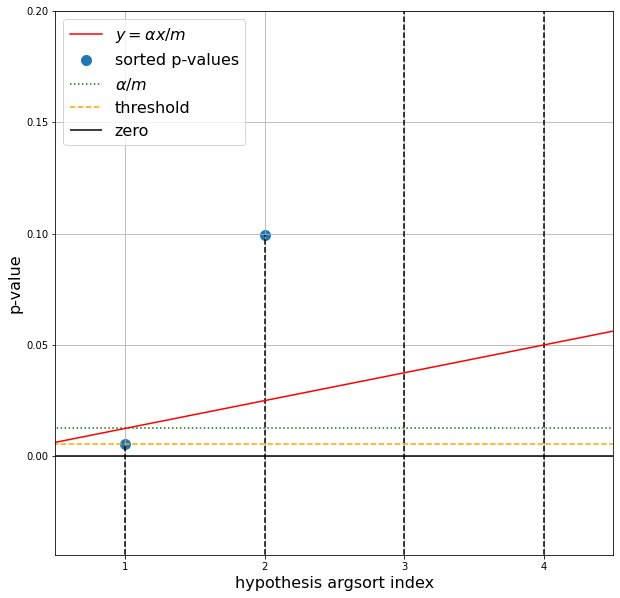

In [13]:
plt.figure(figsize=(10, 10))

indices = np.arange(1, len(p_values) + 1)
plt.scatter(indices, p_values_sorted, s=100, label='sorted p-values')
plt.vlines(indices, p_values_sorted[0] - 0.1, p_values_sorted, ls='--')

xx = np.linspace(0, 5)
yy = significance_level * xx / len(p_values)
plt.plot(xx, yy, ls='-', color='red',  label=r'$y = \alpha x / m$')

plt.hlines(significance_level / len(p_values), -1, 6, color='green', label=r'$\alpha / m$', ls=':')
plt.hlines(threshold, -1, 6, color='orange', label='threshold', ls='--')
plt.hlines(0, -1, 6, color='black', label='zero', ls='-')

plt.xlim(indices[0] - 0.5, indices[-1] + 0.5)
plt.ylim(p_values_sorted[0] - 0.05, 0.2)
# plt.ylim(p_values_sorted[0] - 0.05, p_values_sorted[-1] + 0.1)

plt.xticks(indices)
plt.legend(fontsize=16, loc='upper left')

plt.xlabel('hypothesis argsort index', fontsize=16)
plt.ylabel('p-value', fontsize=16)
plt.grid()
plt.show()

### Task 2: permutation test

In [14]:
df2 = pd.DataFrame({'person': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P'], 
                    'left': [17.5, 18.4, 16.2, 14.5, 13.5, 18.9, 19.5, 21.1, 17.8, 16.8, 18.4, 17.3, 18.9, 16.4, 17.5, 15], 
                    'right': [17.6, 18.5, 15.9, 14.9, 13.7, 18.9, 19.5, 21.5, 18.5, 17.1, 18.9, 17.5, 19.5, 16.5, 17.4, 15.6]})
df2.head()

,person,left,right
0,A,17.5,17.6
1,B,18.4,18.5
2,C,16.2,15.9
3,D,14.5,14.9
4,E,13.5,13.7


We are interested in comparing the length of left hands and rights from 16 individuals. 

1. Compare histograms for left and right hands length (0.5 points)
2. Calculate independent samples permutation test (2 points)
3. Draw scatter plot for left and right hands length (0.5 points)
4. Calculate paired permutation test (2 points)
5. Which test performs better in this case? Why? (1 point)

For this task I used the following materials about paired test
https://www.biostat.wisc.edu/~kbroman/teaching/labstat/third/notes18.pdf

In [15]:
left_lengths, right_lengths = df2['left'], df2['right']

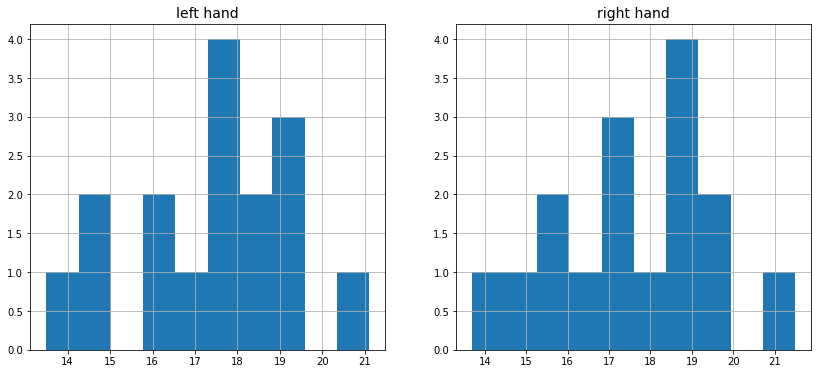

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].hist(left_lengths)
axes[0].grid()
axes[0].set_title('left hand', fontsize=14)

axes[1].hist(right_lengths)
axes[1].grid()
axes[1].set_title('right hand', fontsize=14)

plt.show()

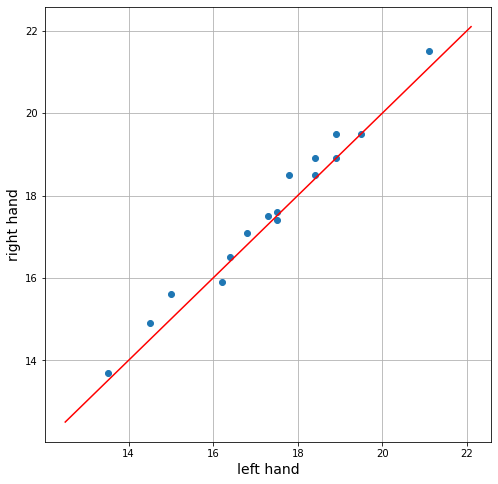

In [17]:
plt.figure(figsize=(8, 8))
plt.scatter(left_lengths, right_lengths)
plt.plot(np.linspace(min(left_lengths) - 1, max(left_lengths) + 1, 100),
         np.linspace(min(left_lengths) - 1, max(left_lengths) + 1, 100), color='red')

plt.xlabel('left hand', fontsize=14)
plt.ylabel('right hand', fontsize=14)

plt.grid()
plt.show()

* permutation test

In [18]:
def permutation_mean_comparison_test(sample_x, sample_y, significance_level, n_permutations=int(1e5)):
    n = len(sample_x)
    
    mean_x, mean_y = np.mean(sample_x), np.mean(sample_y)
    observed_test_statistic = np.abs(mean_x - mean_y)

    sample_united = np.hstack([sample_x, sample_y])
    permuted_test_statistics = []

    for _ in range(n_permutations):
        sample_permuted = np.random.permutation(sample_united)
        mean_x, mean_y = np.mean(sample_permuted[:n]), np.mean(sample_permuted[n:])
        permuted_test_statistics.append(np.abs(mean_x - mean_y))
    
    permuted_test_statistics = np.array(permuted_test_statistics)
    p_value = len(np.where(permuted_test_statistics > observed_test_statistic)[0]) / n_permutations

    return p_value < significance_level, p_value

In [19]:
significance_level = 0.7
hypothesis_denied, p_value = permutation_mean_comparison_test(left_lengths, right_lengths, significance_level)
print(f'hypothesis about left hand length being equal to right hand length')
print(f'significance level: {significance_level}, denied: {hypothesis_denied}, p-value: {p_value:.4f}')

hypothesis about left hand length being equal to right hand length
significance level: 0.7, denied: False, p-value: 0.7343


* paired permutation test

In [20]:
# def paired_mean_comparison_test(sample_x, sample_y, significance_level, n_iterations=1000):
#     differences = np.abs(sample_x - sample_y)
#     n = len(differences)
#     mean_estimation = np.mean(differences)
#     variance_estimation = np.var(differences)

#     test_statistic = np.abs(mean_estimation / np.sqrt(variance_estimation / n))
#     quantile = stats.t.ppf(1 - significance_level / 2, df=n - 1)
#     p_value = 2 * (1 - stats.norm.cdf(test_statistic))

#     return test_statistic > quantile, p_value

In [21]:
def paired_mean_comparison_test(sample_x, sample_y, significance_level, n_iterations=int(1e4)):
    n = len(sample_x)
    
    mean_x, mean_y = np.mean(sample_x), np.mean(sample_y)
    observed_test_statistic = np.abs(mean_x - mean_y)

    sample_ziped = np.array(list(zip(sample_x, sample_y)))
    permuted_test_statistics = []

    for _ in range(n_iterations):
        sample_ziped = np.array(list(zip(sample_x, sample_y)))
        permutation_indices = np.random.rand(n) > 0.5
        
        sample_ziped[permutation_indices] = np.flip(sample_ziped[permutation_indices], axis=1)
        sample_permuted = sample_ziped.T.ravel()

        mean_x, mean_y = np.mean(sample_permuted[:n]), np.mean(sample_permuted[n:])
        permuted_test_statistics.append(np.abs(mean_x - mean_y))
    
    permuted_test_statistics = np.array(permuted_test_statistics)
    p_value = len(np.where(permuted_test_statistics > observed_test_statistic)[0]) / n_iterations

    return p_value < significance_level, p_value

In [22]:
significance_level = 0.05
hypothesis_denied, p_value = paired_mean_comparison_test(left_lengths, right_lengths, significance_level)
print(f'hypothesis about left hand length being equal to right hand length')
print(f'significance level: {significance_level}, denied: {hypothesis_denied}, p-value: {p_value:.4f}')

hypothesis about left hand length being equal to right hand length
significance level: 0.05, denied: True, p-value: 0.0069


We can see that paired test is much more sensitive and requires extremely more evidence for the null hupothesis about 
left hand length being equal to right hand length. I suppose that paired test is more relevant than permutation test in this case

### Task 3: computational approach to hypothesis testing

Recommended reading: http://allendowney.blogspot.com/2016/06/there-is-still-only-one-test.html

Consider the following dataset (service hours between failures of the air-conditioning equipment in a Boeing 720 jet aircraft , Proschan, 1963):

In [23]:
sample = np.array([3, 5, 7, 18, 43, 85, 91, 98, 100, 130, 230, 487])

This sample was sorted for easier presentation.

1. Compute an estimate of the median time between failures (1 point)
2. Consider the null hypothesis $H_0$ to be: "median time between failures is one week" (1 point)
3. What family of distributions will you choose for this kind of data under $H_0$? (1 point)
4. Choose a test statistic to measure the deviation from $H_0$ (1 point)
5. Check whether you can reject $H_0$ at significance level 5% and calculate the corresponding approximate $p$-value. Use 10,000 simulations for your experiment (1 point)
6. Plot histogram of the simulated values of the test statistic and mark the observed value and threshold that you obtained (1 bouns point)

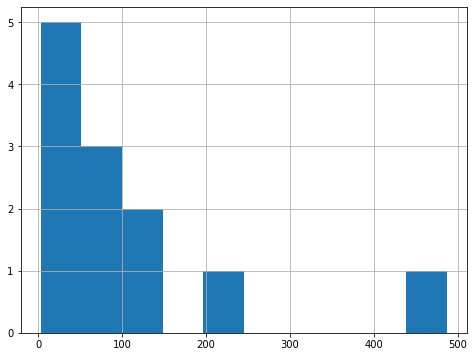

In [24]:
plt.figure(figsize=(8, 6))
plt.hist(sample)
plt.grid()
plt.show()

Maybe we can use exponential distribution. In such case, we should consider MLE equivariance and use the estimation of parameter $\lambda$ of 
exponential distribution from the previous homework in order to get MLE for median $m$
$$F(m) = 1 - \exp(-\lambda m) = 0.5,\;\exp(-\lambda m) = 0.5,\;\lambda m = \ln{2} \Longrightarrow 
m = g(\lambda) = \frac{\ln{2}}{\lambda}$$

$$\hat{m}_n = g(\hat\lambda_n) = \frac{\ln{2}}{\hat\lambda_n} = \frac{\ln{2}}{n}\sum\limits_{i = 1}^n x_i$$

Now we only need to find the coefficient of asymptotic normality which can be expressed through the variance of MLE for median
$$\mathbb{D}\hat{m}_n = \frac{\big[\ln{2}\big]^2\mathbb{D}x_n}{n} = \frac{1}{n}\left[\frac{\ln{2}}{\lambda}\right]^2 = \frac{m^2}{n}$$

So the test statistic has the following form
$$\frac{\hat{m}_n - m}{\sqrt{\mathbb{D}\hat{m}_n}} = \frac{\lambda\sqrt{n}}{\ln{2}}
\left[\frac{\ln{2}}{n}\sum\limits_{i = 1}^n x_i - m\right] = \lambda\sqrt{n}
\left[\frac{1}{n}\sum\limits_{i = 1}^n x_i - \frac{m}{\ln{2}}\right] \leadsto \text{N}_{0, 1}$$

In [25]:
median_estimation = np.log(2) * np.mean(sample)
median_hypothetical = 1. * 7. * 24.

In [26]:
print(f'MLE for median is {median_estimation:.4f}, null hypothesis is that the true median equals {median_hypothetical}')

MLE for median is 74.9177, null hypothesis is that the true median equals 168.0


In [27]:
def exponential_mle_median_test(sample, median_hypothetical, significance_level, n_iterations=int(1e5)):
    n = len(sample)
    lambda_hypothetical = np.log(2) / median_hypothetical
    
    median_estimation = np.log(2) * np.mean(sample)
    variance_estimation = median_hypothetical ** 2 / n
    test_statistic = np.abs(median_estimation - median_hypothetical) / np.sqrt(variance_estimation)

    n_out = 0
    history = [test_statistic]

    for i in range(n_iterations):
        sample_generated = stats.expon.rvs(size=n, scale=1 / lambda_hypothetical)
        median_estimation_generated = np.log(2) * np.mean(sample_generated)
        # variance_estimation = median_hypothetical ** 2 / n
        test_statistic_generated = np.abs(median_estimation_generated - median_hypothetical) / np.sqrt(variance_estimation)
        
        history.append(test_statistic_generated)
        n_out += int(test_statistic_generated > test_statistic)
    
    p_value_generated = n_out / n_iterations
    return p_value_generated < significance_level, p_value_generated, history

In [28]:
significance_level = 0.05
hypothesis_denied, p_value, history = exponential_mle_median_test(sample, median_hypothetical, significance_level)
print(f'hypothesis about exponential median being equal to {median_hypothetical}')
print(f'significance level: {significance_level}, denied: {hypothesis_denied}, p-value: {p_value:.4f}')

hypothesis about exponential median being equal to 168.0
significance level: 0.05, denied: True, p-value: 0.0486


According to this criterion, we do not have enough evidence against the null hypothesis, so can not reject it (but this conclusion may change with random seed, because we are right on the edge between two regions)

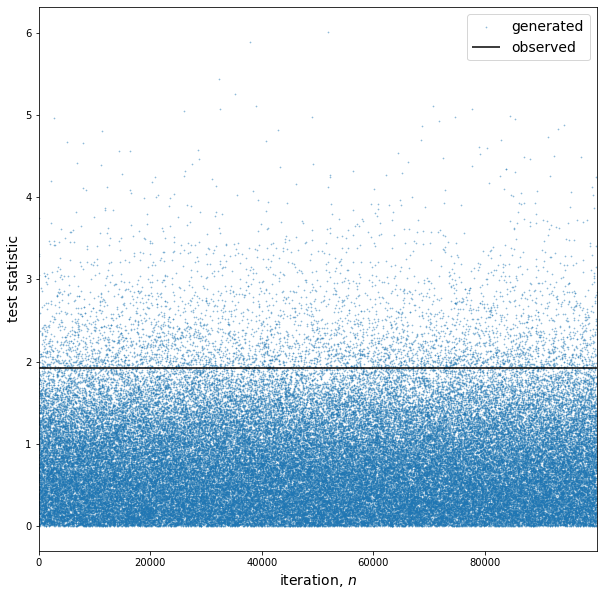

In [29]:
plt.figure(figsize=(10, 10))

iterations = np.arange(int(1e5))
plt.scatter(iterations, history[1:], marker='x', s=0.5, alpha=0.5)
plt.hlines(history[0], -1, int(1e5) + 1)

plt.xlim(iterations[0] - 0.5, iterations[-1] + 0.5)
plt.legend(['generated', 'observed'], fontsize=14, loc='upper right')
plt.xlabel('iteration, $n$', fontsize=14)
plt.ylabel('test statistic', fontsize=14)
plt.show()

---

Another way is to use sample median. In such case, using the results of previous home assignment, the asymptotic normality coefficient can be found as follows

$$\hat{m}_n = x_{[n / 2]},\;\mathbb{E}\hat{m}_n = m,\;\mathbb{D}\hat{m}_n = \frac{1}{4nf(m)^2},\;
f(m) = \lambda\exp\big[-\lambda m\big] = \frac{\lambda}{2}$$
$$\frac{\hat{m}_n - m}{\sqrt{\mathbb{D}\hat{m}_n}} = \lambda\sqrt{n}\big[x_{[n / 2]} - m\big] \leadsto \text{N}_{0, 1}$$

In [30]:
median_estimation = np.median(sample)
median_hypothetical = 1. * 7. * 24.

In [31]:
print(f'sample median is {median_estimation:.4f}, null hypothesis is that the true median equals {median_hypothetical}')

sample median is 88.0000, null hypothesis is that the true median equals 168.0


In [32]:
def exponential_sample_median_test(sample, median_hypothetical, significance_level, n_iterations=int(1e5)):
    n = len(sample)
    lambda_hypothetical = np.log(2) / median_hypothetical
    
    median_estimation = np.median(sample)
    variance_estimation = 1 / (lambda_hypothetical ** 2 * n)
    test_statistic = np.abs(median_estimation - median_hypothetical) / np.sqrt(variance_estimation)

    n_out = 0
    history = [test_statistic]
    for i in range(n_iterations):
        sample_generated = stats.expon.rvs(size=n, scale=1 / lambda_hypothetical)
        median_estimation_generated = np.median(sample_generated)
        # variance_estimation = 1 / (lambda_hypothetical ** 2 * n)
        test_statistic_generated = np.abs(median_estimation_generated - median_hypothetical) / np.sqrt(variance_estimation)
        
        history.append(test_statistic_generated)
        n_out += int(test_statistic_generated > test_statistic)
    
    p_value_generated = n_out / n_iterations
    return p_value_generated < significance_level, p_value_generated, history

    # p_value = 2 * (1 - stats.norm.cdf(test_statistic))
    # return p_value < significance_level, p_value

In [33]:
significance_level = 0.05
hypothesis_denied, p_value, history = exponential_sample_median_test(sample, median_hypothetical, significance_level)
print(f'hypothesis about exponential median being equal to {median_hypothetical}')
print(f'significance level: {significance_level}, denied: {hypothesis_denied}, p-value: {p_value:.4f}')

hypothesis about exponential median being equal to 168.0
significance level: 0.05, denied: False, p-value: 0.2177


Test based on sample median with asymptotic variance for this estimation may have significant errors due to small sample size, but we do not 
have enough evidence against the null hypothesis

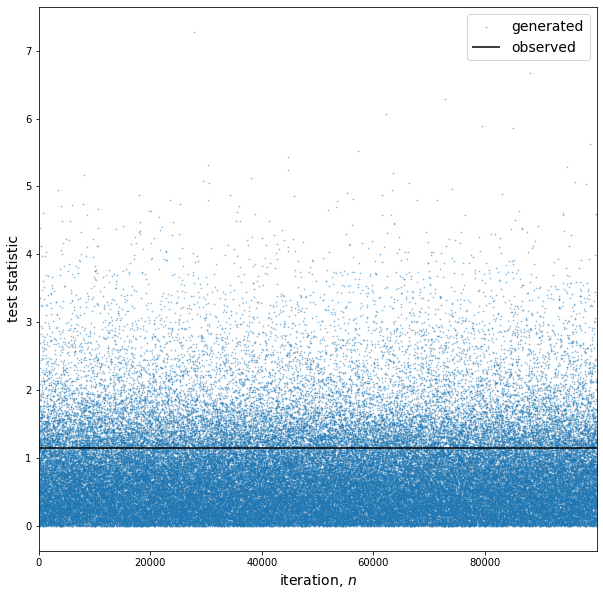

In [34]:
plt.figure(figsize=(10, 10))

iterations = np.arange(int(1e5))
plt.scatter(iterations, history[1:], marker='x', s=0.5, alpha=0.5)
plt.hlines(history[0], -1, int(1e5) + 1)

plt.xlim(iterations[0] - 0.5, iterations[-1] + 0.5)
plt.legend(['generated', 'observed'], fontsize=14, loc='upper right')
plt.xlabel('iteration, $n$', fontsize=14)
plt.ylabel('test statistic', fontsize=14)
plt.show()

In [35]:
lambda_hypothetical = np.log(2) / median_hypothetical
sample_generated = stats.expon.rvs(size=len(sample), scale=1 / lambda_hypothetical)

In [36]:
np.median(sample_generated), median_hypothetical

(128.63902273471723, 168.0)

### Task 4

In 1861, 10 essays appeared in the New Orleans Daily Crescent. They
were signed “Quintus Curtius Snodgrass” and some people suspected
they were actually written by Mark Twain. To investigate this, we will
consider the proportion of three letter words found in an author’s work.
From eight Twain essays we have:

In [37]:
x = np.array([.225, .262, .217, .240, .230, .229, .235, .217])

In [38]:
len(x), np.mean(x)

(8, 0.231875)

From 10 Snodgrass essays we have:

In [39]:
y = np.array([.209, .205, .196, .210, .202, .207, .224, .223, .220, .201])

In [40]:
len(y), np.mean(y)

(10, 0.2097)

1. Perform a Wald test for equality of the means. Use the nonparametric plug-in estimator. Report the $p$-value and a 95% confidence
interval for the difference of means. What do you conclude? (1.5 points)
2. Now use a permutation test to avoid the use of large sample methods.
What is your conclusion? (Brinegar (1963)) (1.5 points)
3. Assume that samples do indeed come from different populations. Additionally, observed sample means and variaces for the two samples are equal to the true values for the respective population. Estimate the power of the two tests above under two model distributions for the data: Normal and [Beta](https://en.wikipedia.org/wiki/Beta_distribution) (use the same family for both samples) (2 points)

In [41]:
def some_mean_comparison_test(sample_x, sample_y, significance_level):
    n_x, n_y = len(sample_x), len(sample_y)
    mean_estimation_x, mean_estimation_y = np.mean(sample_x), np.mean(sample_y)
    variance_estimation_x, variance_estimation_y = np.var(sample_x), np.var(sample_y)

    variance_estimation = variance_estimation_x / n_x + variance_estimation_y / n_y
    test_statistic = np.abs((mean_estimation_x - mean_estimation_y) / np.sqrt(variance_estimation))
    
    quantile = stats.norm.ppf(1 - significance_level / 2)
    p_value = 2 * (1 - stats.norm.cdf(test_statistic))

    return test_statistic > quantile, p_value

### Using Wald's test

In [42]:
significance_level = 0.05
hypothesis_denied, p_value = some_mean_comparison_test(x, y, significance_level)
print(f'hypothesis about Quintus Curtius Snodgrass being Mark Twain')
print(f'significance level: {significance_level}, denied: {hypothesis_denied}, p-value: {p_value:.4f}')

hypothesis about Quintus Curtius Snodgrass being Mark Twain
significance level: 0.05, denied: True, p-value: 0.0001


There is strong evidence that the means of two samples are different, so we can reject the null hypothesis

---

* finding the power of criterion in case of alternative hypothesis.

Given two samples $\mathcal{X}_n = (x_1, x_2, \dots, x_n)$ and $\mathcal{Y}_m = (y_1, y_2, \dots, y_m)$ and 
alternative hypothetical distributions $F_\mathcal{X}$ and $F_\mathcal{Y}$, the test power in this task is defined as
$$\mathbb{P}\Big[\varphi(\mathcal{X}_n, \mathcal{Y}_m)\bigg|_{\text{null}} = 1|
\mathcal{X}_n \sim F_{\mathcal{X}}\bigg|_{\text{null}}, \mathcal{Y}_n \sim F_{\mathcal{Y}}\bigg|_{\text{null}}\Big]$$

In turn, the criterion $\varphi\bigg|_{\text{null}}$ is defined as
$$T_{n, m} = T(\mathcal{X}_n, \mathcal{Y}_m) = \overline{x}_n - \overline{y}_n \sim F_{T}\bigg|_{\text{null}},\;
\mathbb{E}T_{n, m} = 0,\;\mathbb{D}T_{n, m} = \sigma^2_{n, m} = \cfrac{\mathbb{D}x_n}{n} + \cfrac{\mathbb{D}y_m}{m}$$
$$C_{n, m} = \Big(-z_{1 - \alpha/2}\sigma_{n, m}, z_{1 - \alpha/2}\sigma_{n, m}\Big),\;
\varphi(\mathcal{X}_n, \mathcal{Y}_m)\bigg|_{\text{null}} = \mathbb{I}\Big[T_{n, m} \not\in C_{n, m}\Big]$$

Note that here we assume that $F_{\mathcal{X}}$ and $F_{\mathcal{Y}}$ come from the null hypothesis. 
So we need to evaluate the following expression under the alternative hypothesis
$$\mathcal{X}_n \sim F_{\mathcal{X}}\bigg|_{\text{alt}}, \mathcal{Y}_n \sim F_{\mathcal{Y}}\bigg|_{\text{alt}} 
\Longrightarrow T_{n, m} \sim F_{T}\bigg|_{\text{alt}}$$
$$\mathbb{P}\Big[T_{n, m} \not\in C_{n, m}|T_{n, m} \sim F_{T}\bigg|_{\text{alt}}\Big] = 
\mathbb{P}\Big[T_{n, m} > z_{1 - \alpha/2}\sigma_{n, m} \lor T_{n, m} < -z_{1 - \alpha/2}\sigma_{n, m}|T_{n, m} \sim F_{T}\bigg|_{\text{alt}}\Big] =$$
$$= \mathbb{P}\Big[T_{n, m} > z_{1 - \alpha/2}\sigma_{n, m}|T_{n, m} \sim F_{T}\bigg|_{\text{alt}}\Big] + 
\mathbb{P}\Big[T_{n, m} < -z_{1 - \alpha/2}\sigma_{n, m}|T_{n, m} \sim F_{T}\bigg|_{\text{alt}}\Big] =$$
$$= 1 - F_{T}\bigg|_{\text{alt}}\Big[z_{1 - \alpha/2}\sigma_{n, m}\Big] + F_{T}\bigg|_{\text{alt}}\Big[-z_{1 - \alpha/2}\sigma_{n, m}\Big]$$

In [43]:
mean_null = 0

In [44]:
def calculate_boundaries_under_hypothesis(sample_x, sample_y, mean_hypothetical, significance_level):
    n_x, n_y = len(sample_x), len(sample_y)
    mean_estimation_x, mean_estimation_y = np.mean(sample_x), np.mean(sample_y)
    variance_estimation_x, variance_estimation_y = np.var(sample_x), np.var(sample_y)

    variance_estimation = variance_estimation_x / n_x + variance_estimation_y / n_y
    quantile = stats.norm.ppf(1 - significance_level / 2)
    left, right = -quantile * np.sqrt(variance_estimation) + mean_hypothetical, quantile * np.sqrt(variance_estimation) + mean_hypothetical

    return left, right

In [45]:
significance_level = 0.05
left, right = calculate_boundaries_under_hypothesis(x, y, mean_null, significance_level)

Let us first consider normal distribution of $\mathcal{X}_n$ and $\mathcal{Y}_m$
$$T_{n, m} = \overline{x}_n - \overline{y}_n \sim \text{N}_{\mu_T, \sigma^2_T} = F_{T}\bigg|_{\text{alt}}$$
$$\mu_T = \mathbb{E}T_{n, m} = \mathbb{E}\overline{x}_n - \mathbb{E}\overline{y}_n = 
\mu_x - \mu_y,\;\sigma^2_T = \mathbb{D}T_{n, m} = \mathbb{D}\overline{x}_n + \mathbb{D}\overline{y}_n = 
\frac{\sigma^2_x}{n} + \frac{\sigma^2_y}{m}$$

In [46]:
mean_alternative_x, mean_alternative_y = np.mean(x), np.mean(y)
variance_alternative_x, variance_alternative_y = np.var(x), np.var(y)

mean_alternative = np.mean(x) - np.mean(y)
variance_alternative = np.var(x) / len(x) + np.var(y) / len(y)

In [47]:
def calculate_walds_power_under_normal_alternative(mean_alternative, variance_alternative, left, right):
    prob_left = stats.norm.cdf(left, loc=mean_alternative, scale=np.sqrt(variance_alternative))
    prob_right = 1 - stats.norm.cdf(right, loc=mean_alternative, scale=np.sqrt(variance_alternative))

    return prob_left + prob_right

In [48]:
power = calculate_walds_power_under_normal_alternative(mean_alternative, variance_alternative, left, right)
print(f'power of Wald\'s test at significance level {significance_level} is {power:.4f} in case of normal alternative')

power of Wald's test at significance level 0.05 is 0.9764 in case of normal alternative


Futher, let us consider beta distribution of $\mathcal{X}_n$ and $\mathcal{Y}_m$. 
Since humanity has not yet derived the distribution of difference between two beta distributions, 
we can only model it using finite samples. The sacred internet knowledge https://stats.stackexchange.com/questions/12232/calculating-the-parameters-of-a-beta-distribution-using-the-mean-and-variance suggests that parameters of beta distribution 
can be expressed as follows

$$\alpha = \left[\frac{1 - \mu}{\sigma^2} - \frac{1}{\mu}\right]\mu^2,\;
\beta = \alpha\left[\frac{1}{\mu} - 1\right]$$

In [49]:
def calculate_walds_power_under_beta_alternative(mean_alternative_x, variance_alternative_x, 
                                           mean_alternative_y, variance_alternative_y, 
                                           left, right, size_x=len(x), size_y=len(y), n_iterations=int(1e5)):
    alpha_x = ((1 - mean_alternative_x) / variance_alternative_x - 1 / mean_alternative_x) * mean_alternative_x ** 2
    beta_x = alpha_x * (1 / mean_alternative_x - 1)

    alpha_y = ((1 - mean_alternative_y) / variance_alternative_y - 1 / mean_alternative_y) * mean_alternative_y ** 2
    beta_y = alpha_y * (1 / mean_alternative_y - 1)

    n_out = 0
    for i in range(n_iterations):
        xx = stats.beta.rvs(size=size_x, a=alpha_x, b=beta_x)
        yy = stats.beta.rvs(size=size_y, a=alpha_y, b=beta_y)

        t = np.mean(xx) - np.mean(yy)
        n_out += int(t < left) + int(t > right)

    prob = n_out / n_iterations
    return prob

In [50]:
power = calculate_walds_power_under_beta_alternative(mean_alternative_x, variance_alternative_x, 
                                                     mean_alternative_y, variance_alternative_y, 
                                                     left, right)
print(f'power of Wald\'s test at significance level {significance_level} is {power:.4f} in case of beta alternative')

power of Wald's test at significance level 0.05 is 0.9772 in case of beta alternative


### Using permutation test

In [51]:
significance_level = 0.05
hypothesis_denied, p_value = permutation_mean_comparison_test(x, y, significance_level)
print(f'hypothesis about Quintus Curtius Snodgrass being Mark Twain')
print(f'significance level: {significance_level}, denied: {hypothesis_denied}, p-value: {p_value:.4f}')

hypothesis about Quintus Curtius Snodgrass being Mark Twain
significance level: 0.05, denied: True, p-value: 0.0008


We again have strong evidence against the null hypothesis

---

* finding the power of criterion in case of alternative hypothesis.

Here, under the null hypothesis, the test statistic 
$T_{n, m} = \overline{x}_n - \overline{y}_m$ has the uniform distributions $F_{T}\bigg|_{\text{null}}$ over all $(n + m)!$ possible 
permutations of the concatenated samples. 
Moreover, the null hypothesis is formally rejected on significance level $\alpha$ when the test statistic $|T_{n, m}| > t_\alpha$, where
$$t_\alpha = \inf\Big\{t: \mathbb{P}\Big[|T_{n, m}| > t|T_{n, m} \sim F_{T}\bigg|_{\text{null}}\Big] < \alpha\Big\}$$

It can be seen that such value $t_\alpha$ can be expressed through the quantile $u_{1 - \alpha}$ of the null hypothesis 
distribution $F_{T}\bigg|_{\text{null}}$ as
$$t_\alpha = u_{1 - \alpha} = F_{T}^{-1}\bigg|_{\text{null}}\big[1 - \alpha\big]$$

Here we understand that the power of permutation test can be evaluated as follows
$$\mathbb{P}\Big[|T_{n, m}| > t_\alpha| T_{n, m} \sim F_{T}\bigg|_{\text{alt}}\Big] = 
\mathbb{P}\Big[T_{n, m} > t_\alpha \lor T_{n, m} < -t_\alpha| T_{n, m} \sim F_{T}\bigg|_{\text{alt}}\Big] =$$
$$= \mathbb{P}\Big[T_{n, m} > t_\alpha| T_{n, m} \sim F_{T}\bigg|_{\text{alt}}\Big] + 
\mathbb{P}\Big[T_{n, m} < -t_\alpha| T_{n, m} \sim F_{T}\bigg|_{\text{alt}}\Big] =$$
$$= 1 - F_{T}\bigg|_{\text{alt}}\big[t_\alpha\big] + F_{T}\bigg|_{\text{alt}}\big[-t_\alpha\big]$$

In [52]:
def calculate_threshold(sample_x, sample_y, significance_level, n_permutations=int(1e5)):
    n = len(sample_x)
    
    mean_x, mean_y = np.mean(sample_x), np.mean(sample_y)
    observed_test_statistic = np.abs(mean_x - mean_y)

    sample_united = np.hstack([sample_x, sample_y])
    permuted_test_statistics = []

    for _ in range(n_permutations):
        sample_permuted = np.random.permutation(sample_united)
        mean_x, mean_y = np.mean(sample_permuted[:n]), np.mean(sample_permuted[n:])
        permuted_test_statistics.append(np.abs(mean_x - mean_y))
    
    permuted_test_statistics = np.array(permuted_test_statistics)
    threshold = np.quantile(permuted_test_statistics, 1 - significance_level)

    return threshold

In [53]:
significance_level = 0.05
threshold = calculate_threshold(x, y, significance_level)
left, right = -threshold, threshold

For normal alternative distribution of $\mathcal{X}_n$ and $\mathcal{Y}_m$

In [54]:
mean_alternative_x, mean_alternative_y = np.mean(x), np.mean(y)
variance_alternative_x, variance_alternative_y = np.var(x), np.var(y)

mean_alternative = np.mean(x) - np.mean(y)
variance_alternative = np.var(x) / len(x) + np.var(y) / len(y)

In [55]:
power = calculate_walds_power_under_normal_alternative(mean_alternative, variance_alternative, left, right)
print(f'power of permutation test at significance level {significance_level} is {power:.4f} in case of normal alternative')

power of permutation test at significance level 0.05 is 0.9075 in case of normal alternative


And for beta alternative distribution of $\mathcal{X}_n$ and $\mathcal{Y}_m$

In [56]:
power = calculate_walds_power_under_beta_alternative(mean_alternative_x, variance_alternative_x, 
                                                     mean_alternative_y, variance_alternative_y, 
                                                     left, right)
print(f'power of permutation test at significance level {significance_level} is {power:.4f} in case of beta alternative')

power of permutation test at significance level 0.05 is 0.9083 in case of beta alternative


We can see that the power of permutation test is a bit less than the power of Wald's test